# N-day Returns Analysis for Selected Stocks

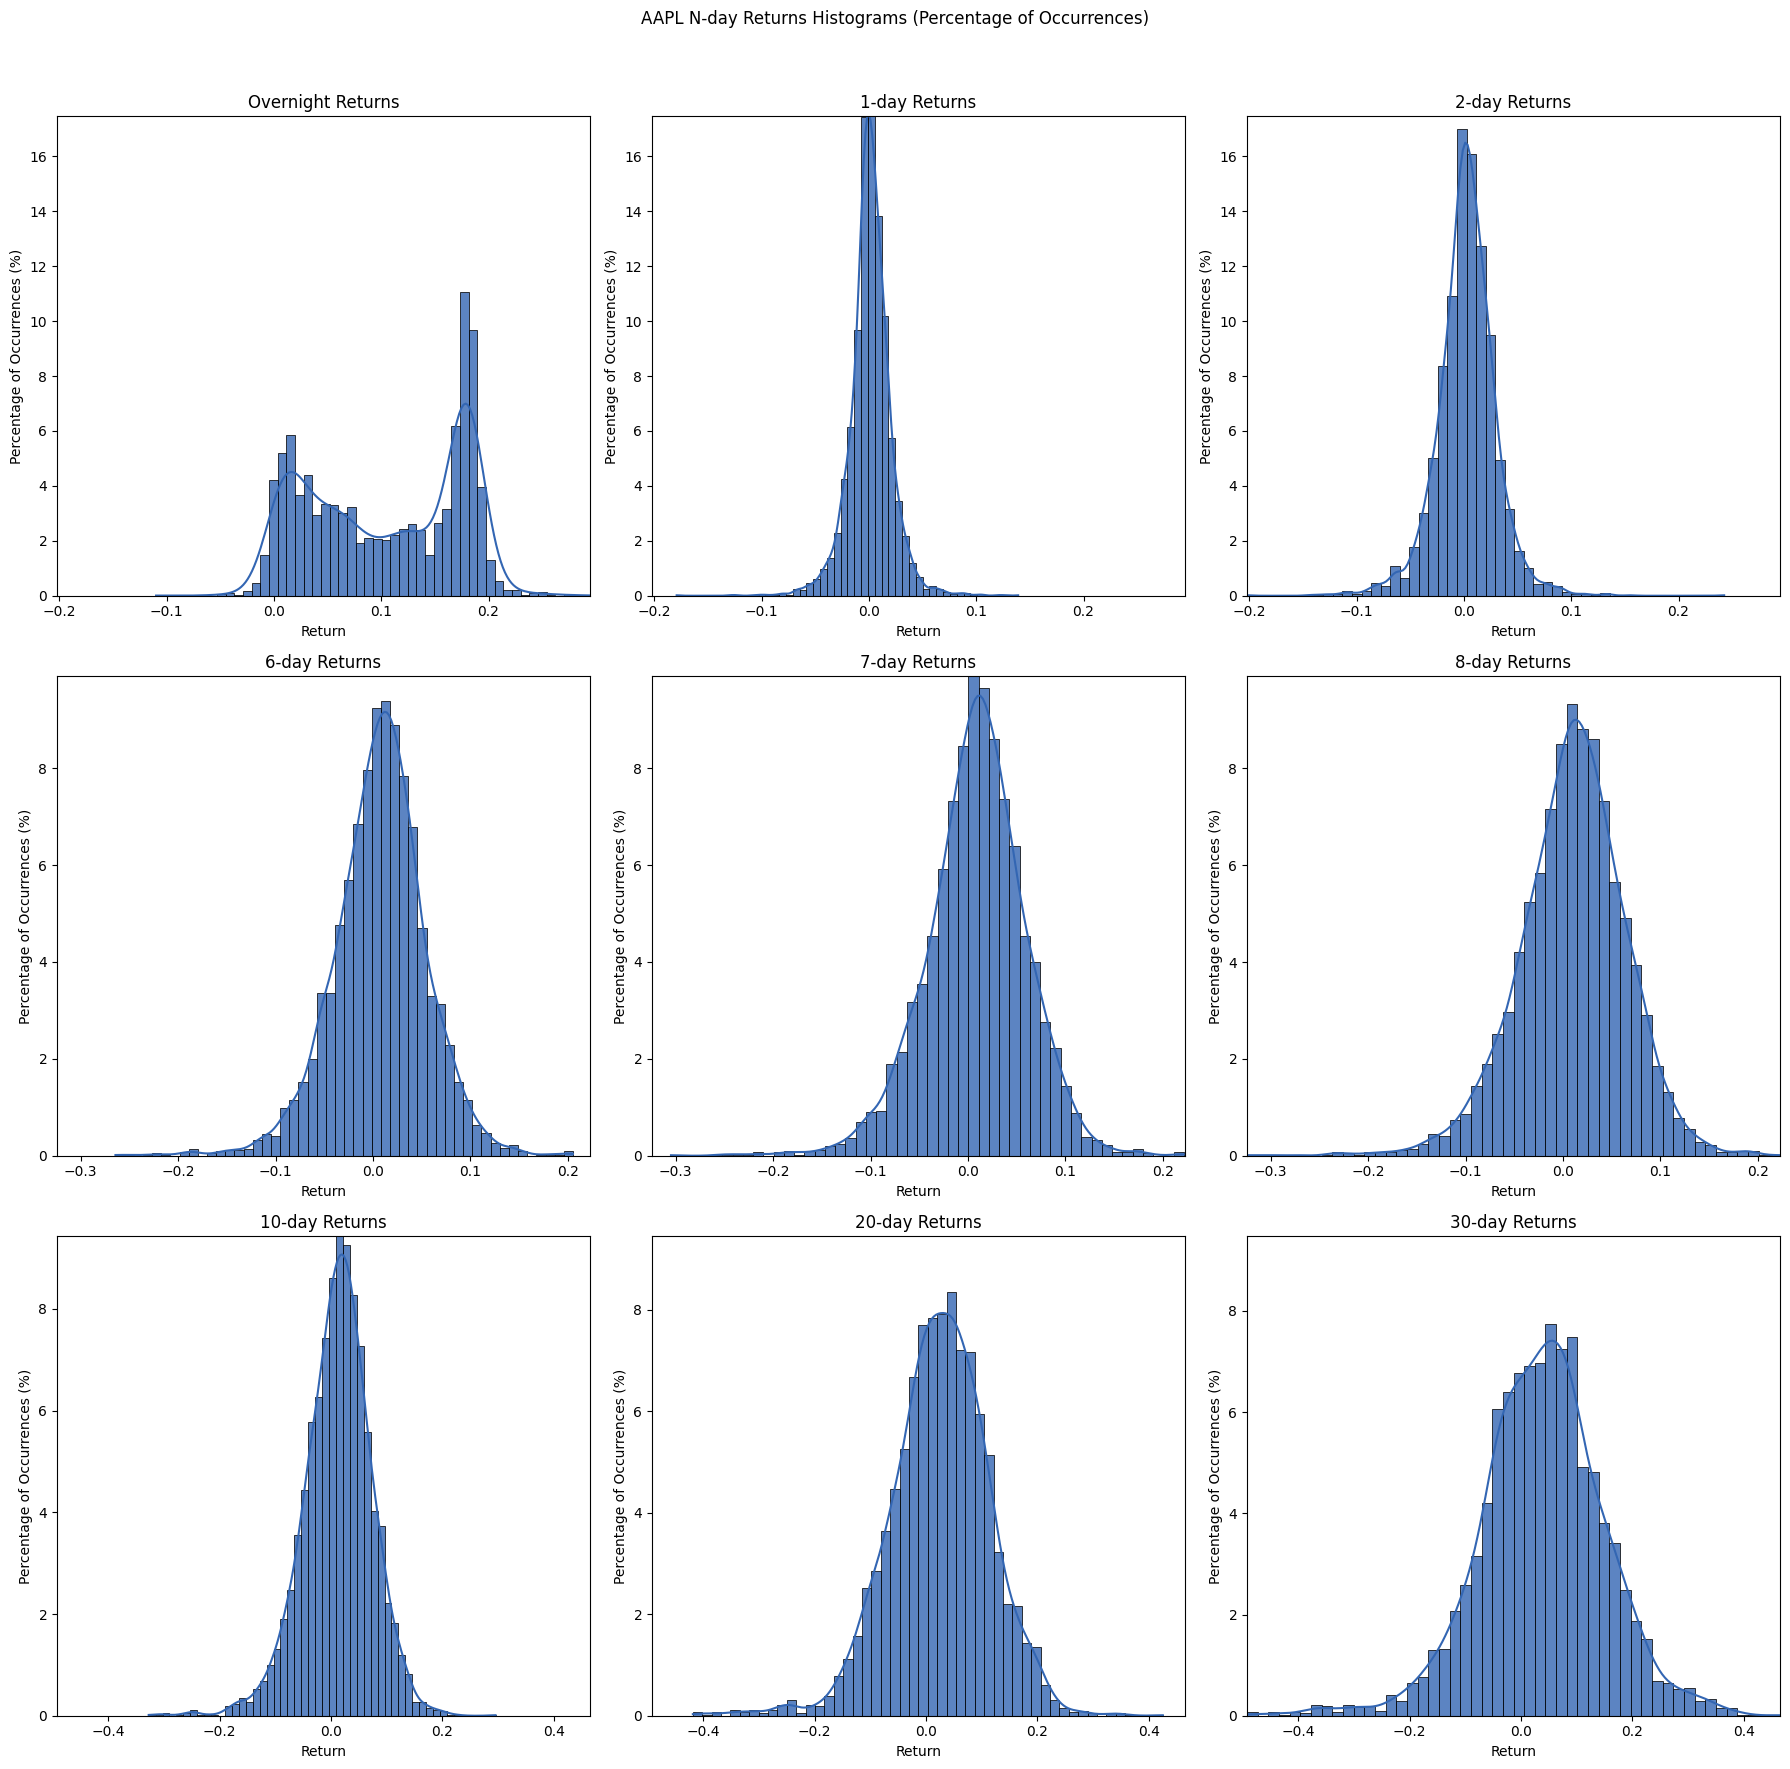

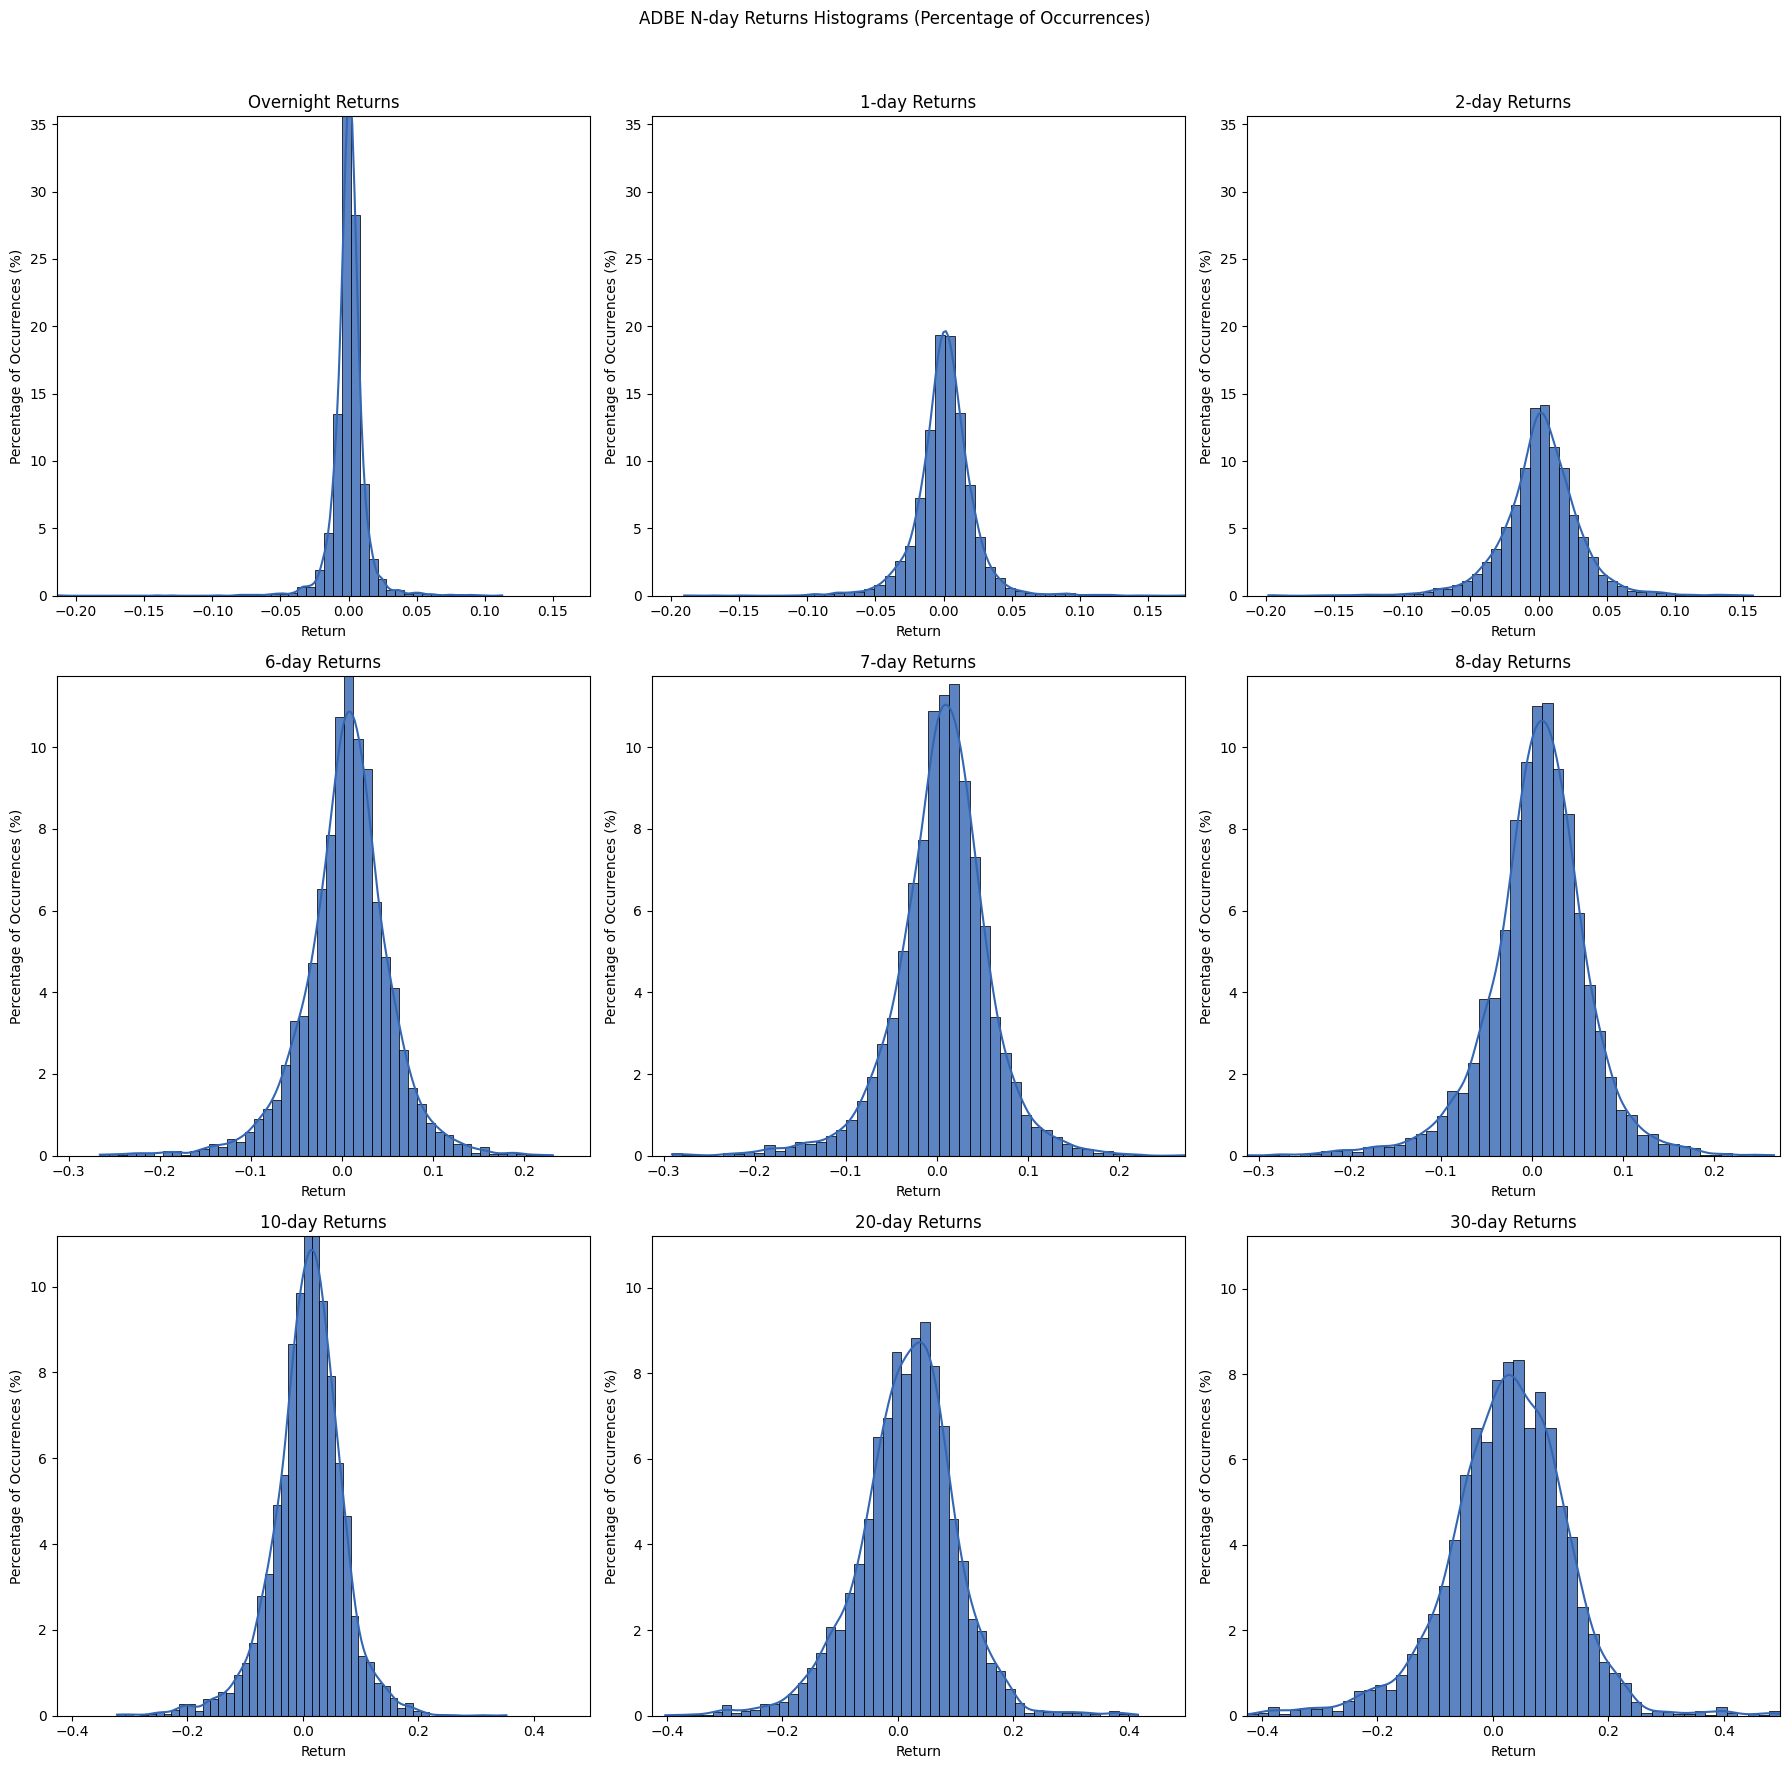

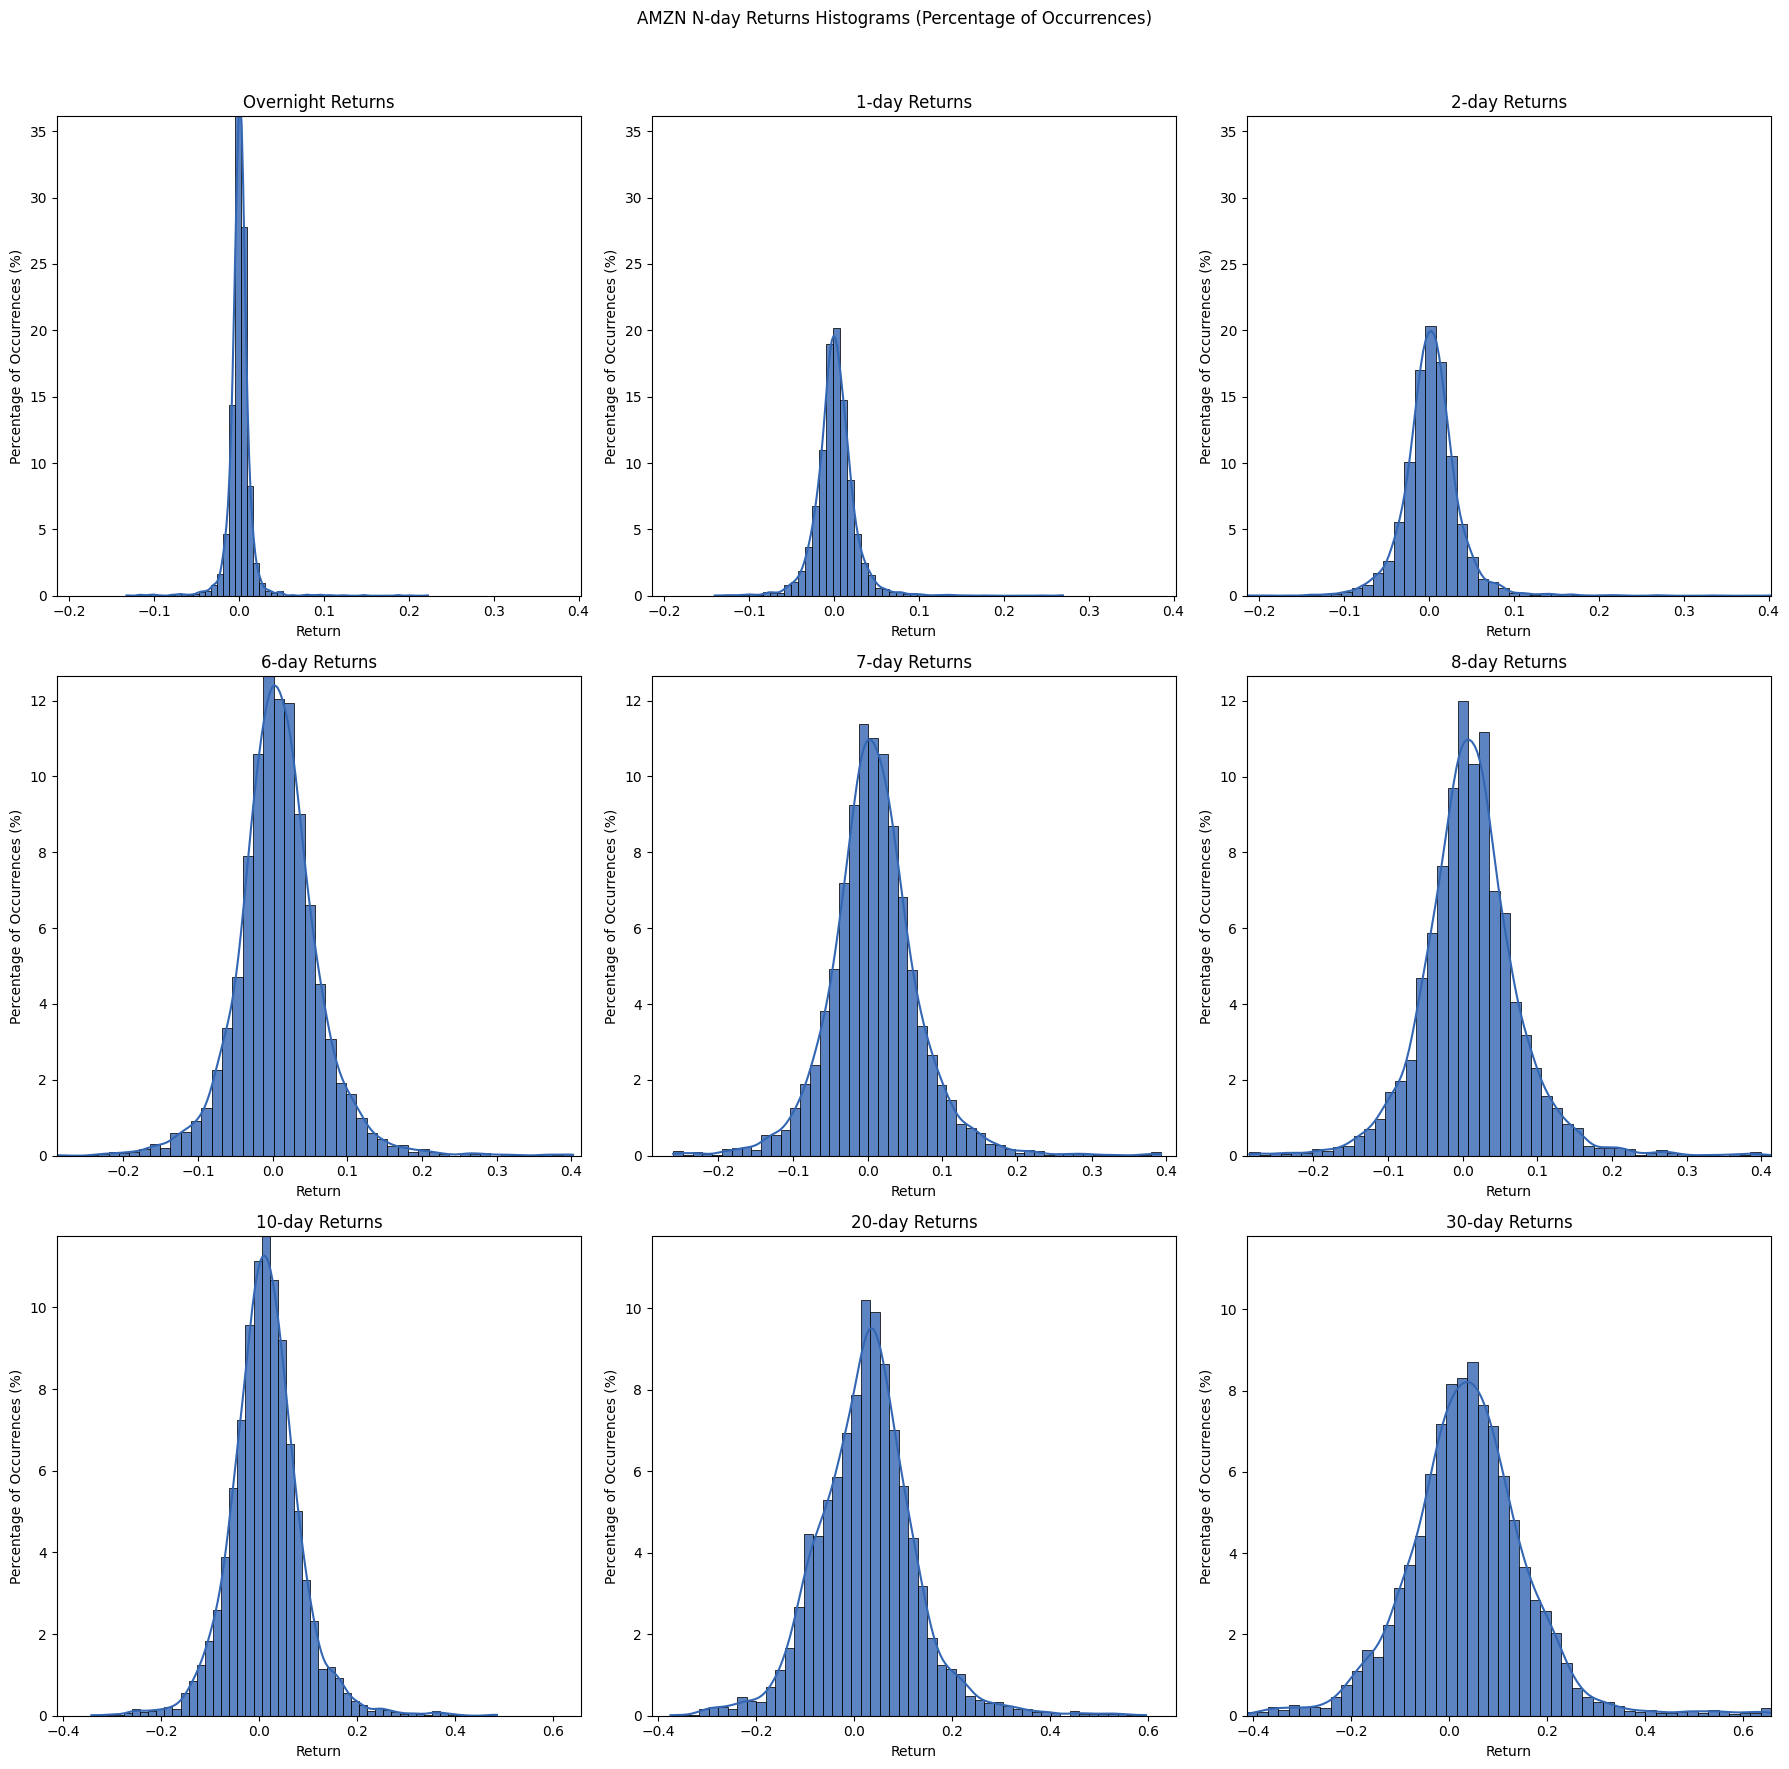

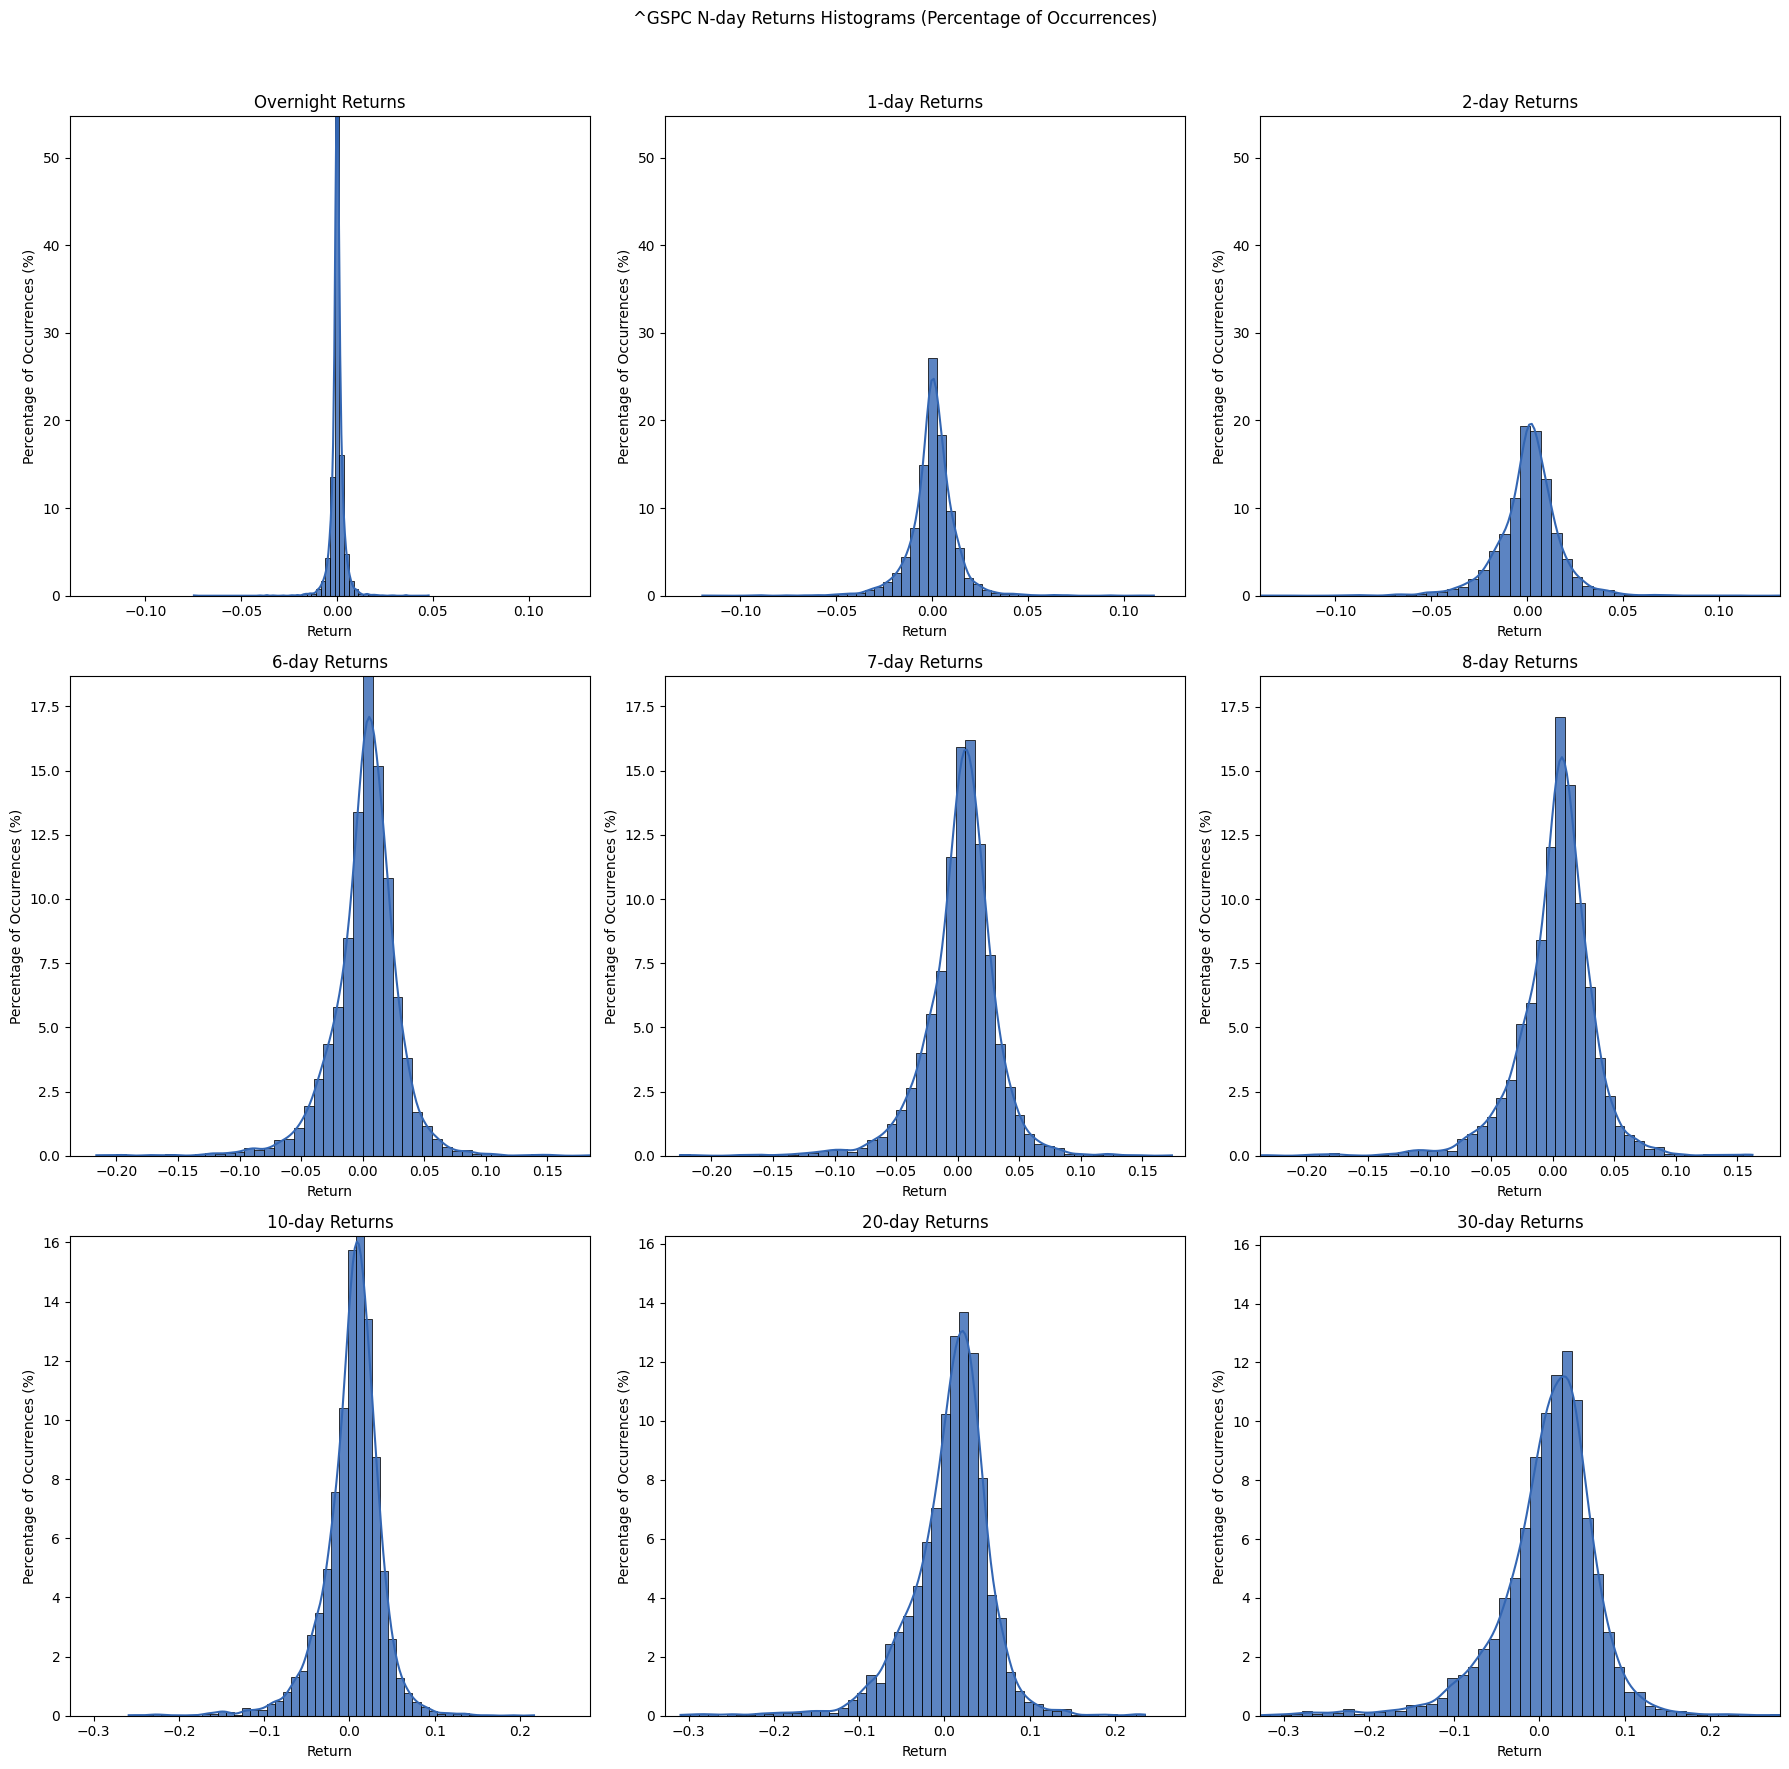

In [2]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_n_day_returns_histograms(df: pd.DataFrame, stocks: list, n_day_periods: list):
    """
    Plots histograms of N-day returns for a list of stocks.

    :param df: DataFrame containing stock data with 'Adj Close' as one of the hierarchical columns.
    :param stocks: List of stock tickers to analyze.
    :param n_day_periods: List of N-day periods for calculating returns.

    :return: None
    """
    # Initialize a dictionary to store N-day returns for each stock
    all_n_day_returns = {}

    # Calculate N-day returns for each stock
    for stock in stocks:
        n_day_returns = {}
        for n in n_day_periods:
            if n == 0:
                # Calculate 0-day (overnight) return
                close_prices = df['Adj Close'][stock]
                open_prices = df['Open'][stock].shift(-1)  # Shift to align with the next day
                n_day_returns[n] = (open_prices / close_prices - 1).dropna()
            else:
                # Calculate n-day return for n > 0
                n_day_returns[n] = df['Adj Close'][stock].pct_change(n).dropna()
        all_n_day_returns[stock] = n_day_returns


    # Generate the plots
    for stock in stocks:
        n_day_returns = all_n_day_returns[stock]

        fig, axes = plt.subplots(3, 3, figsize=(18, 18))
        axes = axes.flatten()
        fig.suptitle(f'{stock} N-day Returns Histograms (Percentage of Occurrences)')

        # Divide n_day_periods into three rows for separate scaling
        row1_days = n_day_periods[:3]
        row2_days = n_day_periods[3:6]
        row3_days = n_day_periods[6:]

        for i, n in enumerate(n_day_periods):
            returns = n_day_returns[n]

            # Determine row-specific x and y-axis limits
            if n in row1_days:
                row_days = row1_days
            elif n in row2_days:
                row_days = row2_days
            else:
                row_days = row3_days

            row_xlim = (min([n_day_returns[day].min() for day in row_days]), 
                        max([n_day_returns[day].max() for day in row_days]))
            row_ylim = (0, max([n_day_returns[day].value_counts(bins=50).max() for day in row_days]) / len(returns) * 100)

            # Plot the histogram
            sns.histplot(returns, bins=50, kde=True, color=(0.2, 0.4, 0.7), alpha=0.8, ax=axes[i], stat="percent")
            if n == 0:
                axes[i].set_title(f'Overnight Returns')
            else:
                axes[i].set_title(f'{n}-day Returns')
            axes[i].set_xlabel('Return')
            axes[i].set_ylabel('Percentage of Occurrences (%)')
            axes[i].set_xlim(row_xlim)
            axes[i].set_ylim(row_ylim)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Sample data loading (Replace this with your actual data loading step)
# For demonstration, I'll use the finance_data_new DataFrame we have already loaded.
df = pd.read_pickle("../data/finance_store.pkl")

# Sample list of stocks and N-day periods
sample_stocks = ['AAPL', 'ADBE', 'AMZN', '^GSPC']
sample_n_day_periods = [0, 1, 2, 6, 7, 8, 10, 20, 30]

# Run the plotting function
plot_n_day_returns_histograms(df, sample_stocks, sample_n_day_periods)


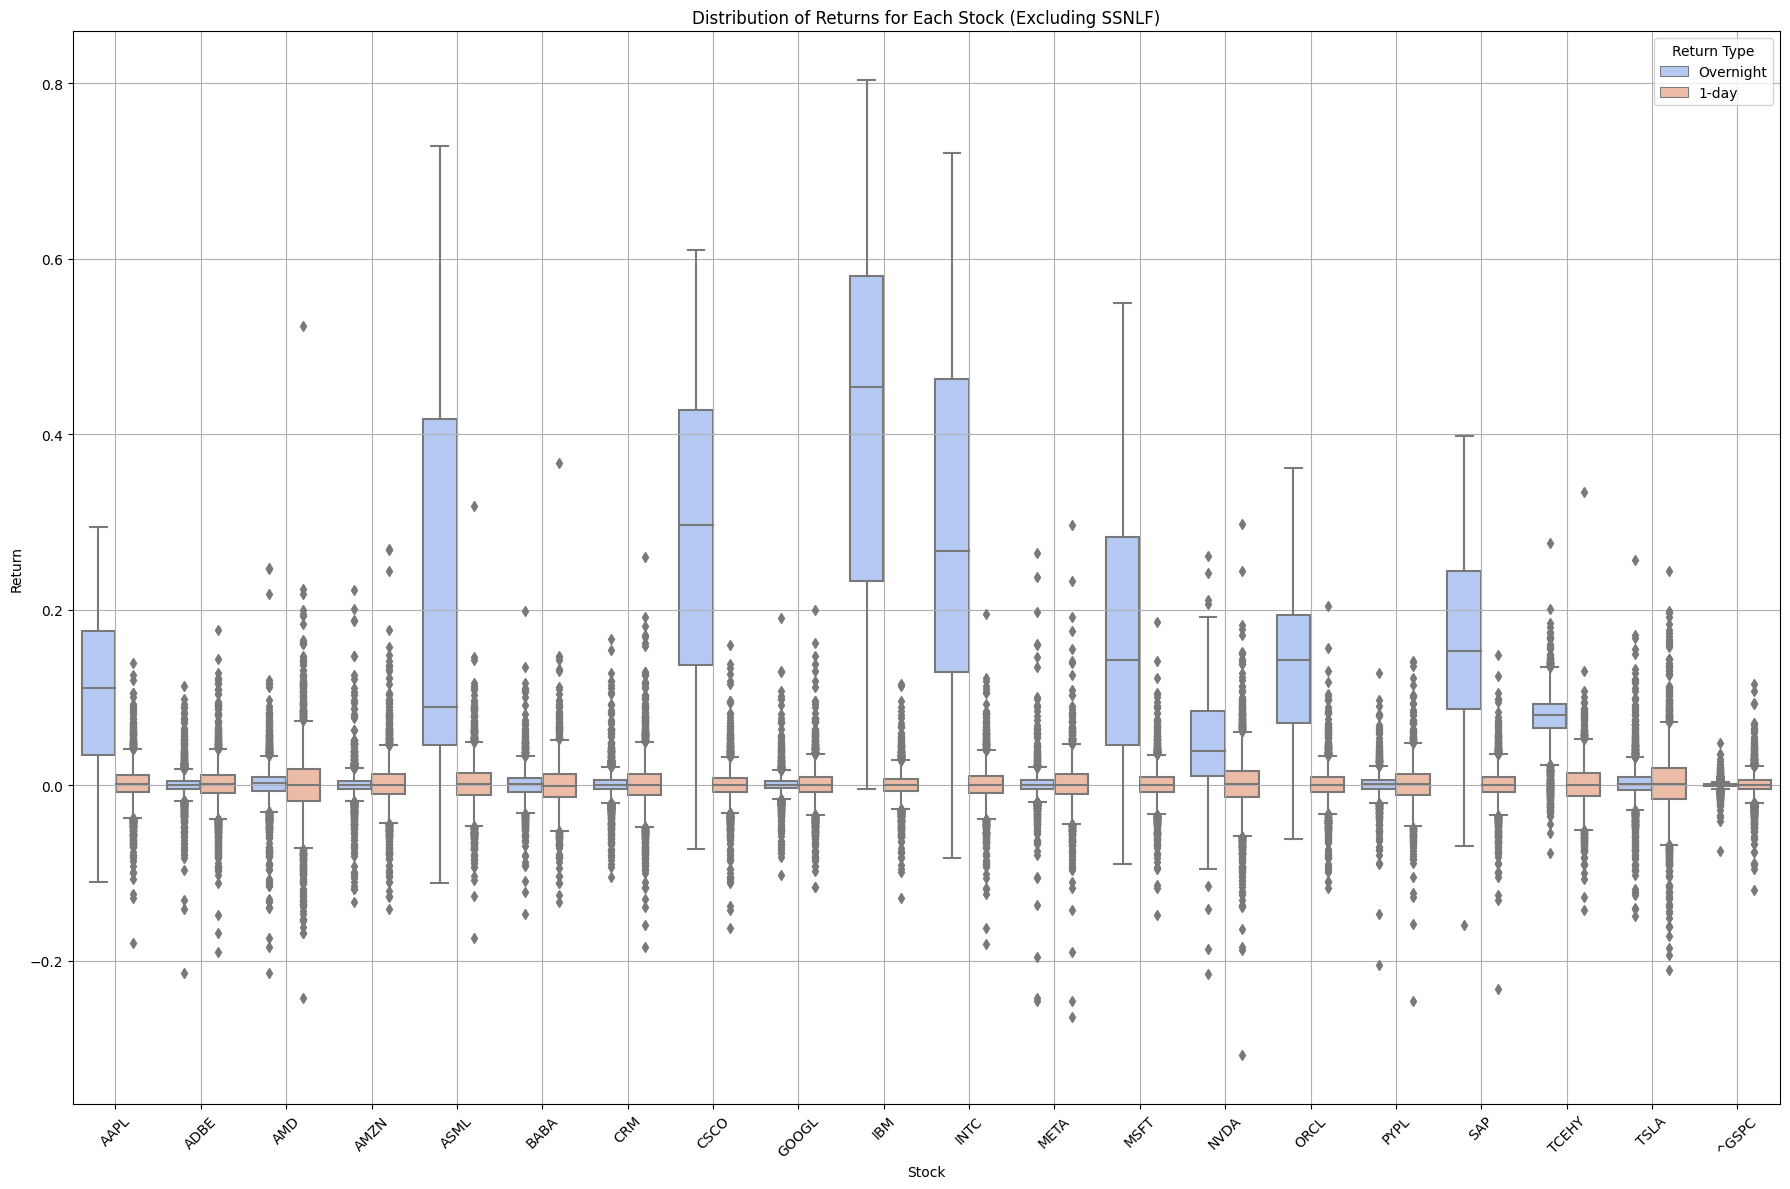

In [10]:
# Function to visualize the distribution of overnight and 1-day returns for each stock (excluding SSNLF) using boxplots
def plot_return_distributions_excluding_SSNLF(df):
    # Prepare data for boxplot
    df_list = []

    for stock in df.columns.levels[1]:
        if stock == 'SSNLF':
            continue  # Skip SSNLF
        # Calculate overnight returns
        close_prices = df['Adj Close'][stock]
        open_prices = df['Open'][stock].shift(-1)  # Shift to align with the next day
        overnight_return = (open_prices / close_prices - 1).dropna()
        
        # Calculate 1-day returns
        one_day_return = df['Adj Close'][stock].pct_change(1).dropna()

        # Ensure both overnight and 1-day returns have the same length by trimming the longer one
        min_length = min(len(overnight_return), len(one_day_return))
        overnight_return = overnight_return.iloc[:min_length]
        one_day_return = one_day_return.iloc[:min_length]

        # Prepare DataFrame for this stock
        stock_df = pd.DataFrame({
            'Overnight': overnight_return,
            '1-day': one_day_return
        })
        stock_df['Stock'] = stock

        df_list.append(stock_df)

    # Combine all individual stock DataFrames into one
    plot_df = pd.concat(df_list).reset_index(drop=True).melt(id_vars=['Stock'], var_name='Return Type', value_name='Return')
    
    # Create the boxplot
    plt.figure(figsize=(18, 12))
    sns.boxplot(x='Stock', y='Return', hue='Return Type', data=plot_df, palette="coolwarm")
    plt.title('Distribution of Returns for Each Stock (Excluding SSNLF)')
    plt.xlabel('Stock')
    plt.ylabel('Return')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize the distribution of overnight and 1-day returns for each stock (excluding SSNLF) using boxplots
plot_return_distributions_excluding_SSNLF(df)


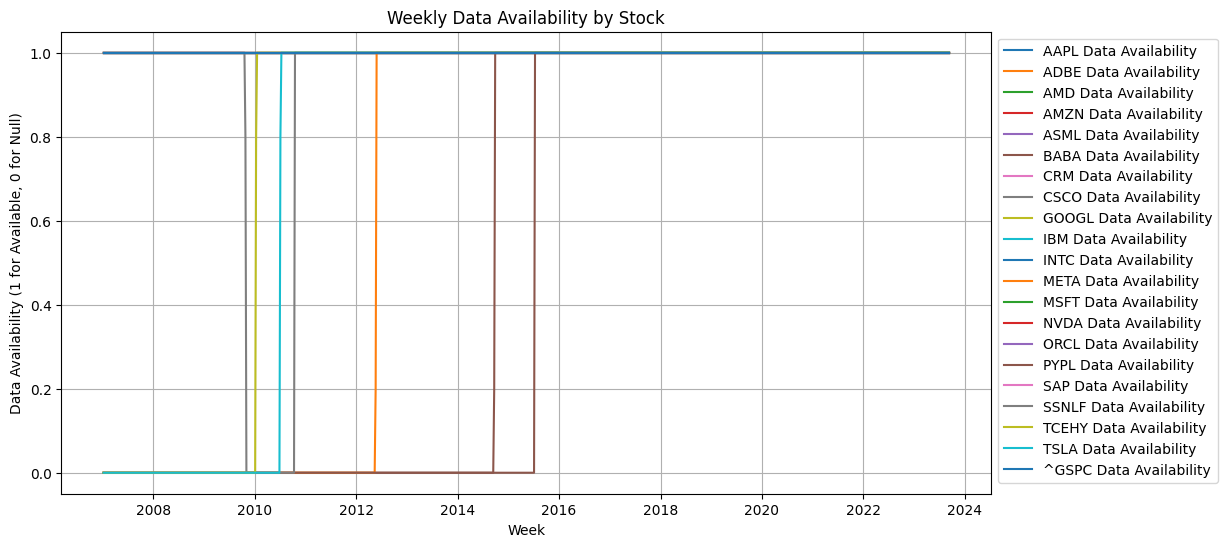

In [6]:

def plot_data_availability_for_all_stocks(data_frame):
    plt.figure(figsize=(12, 6))
    
    # Loop through all the stock tickers in the DataFrame
    for stock in data_frame.columns.levels[1]:
        # Get weekly null counts for the stock
        weekly_null_count_stock = data_frame.xs(stock, axis=1, level=1).resample('W').apply(lambda x: x.isnull().sum())
        # Calculate the number of weekly days for the stock (null or not)
        weekly_days_stock = data_frame.xs(stock, axis=1, level=1).resample('W').size()
        # Compute the weekly null percentage for the stock
        weekly_null_percentage_stock = (weekly_null_count_stock.sum(axis=1) / (weekly_days_stock * len(weekly_null_count_stock.columns)))
        is_data_available = 1 - weekly_null_percentage_stock
        # Plot the data availability for the stock
        sns.lineplot(x=is_data_available.index, y=is_data_available, label=f"{stock} Data Availability")
    
    plt.title('Weekly Data Availability by Stock')
    plt.xlabel('Week')
    plt.ylabel('Data Availability (1 for Available, 0 for Null)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

# Generate a single plot for all stocks using the modified function
plot_data_availability_for_all_stocks(df)